# **Reconnaissance d'orateur**

### **<span style="color: #DC143C">Objectif</span>**

Ce notebook a pour ambition de construire un modèle de **reconnaissance d'orateur** entre les paroles de deux présidents : **François Mitterand** et **Jacques Chirac**.  

### **<span style="color: #DC143C">Méthode</span>**

Nous comparerons les performances de différents modèles puis utiliserons leurs meilleurs paramètres afin d'évaluer l'influence de différents pré-traitements sur la performance. Enfin, nous appliquerons les traitements optimaux sur les données test. Les résultats seront sauvegardés dans un ficher .txt.

### **<span style="color: #DC143C">Plan</span>**

1. Chaîne de pré-traitements
    1. Importation des données
    2. Pré-traitements des données
    3. Apprentissage d'un classifieur
    4. Construction de la chaîne
2. Exploitation de la chaîne de pré-traitements
    1. Optimisation des hyperparamètres
    2. Campagne de test sur les pré-traitements des données possibles
3. Application des résultats aux données de test
    1. Modèle final
    2. Application aux données du corpus de test

## **<span style="color: #40E0D0">1. Chaîne de pré-traitements</span>**

### **<span style="color: #DC143C">A. Importation des données</span>**

Les données sont contenues dans le dossier data. Nous avons à notre disposition deux jeux de données :
- corpus.tache1.learn
- corpus.tache1.test

Le premier contient des paroles de discours des présidents étiquettées, tandis que celles du second ne le sont pas.  
Pour cette raison, nous utiliserons deux fonctions différentes pour importer ces jeux de données.

In [1]:
# Chargement des librairies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import codecs
import re

In [2]:
# Fonctions utiles

def compte_lignes(filename):
    """
    Retourne le nombre de lignes d'un fichier texte.

    Args:
        filename: fichier texte

    Returns:
        count: le nombre de lignes du fichier
    """
    count = 0
    with open(filename, "r") as f:
        for line in f:
            count += 1
    return count

def extract_labels_txt(filename, n_lines):
    """
    Retourne les phrases d'un fichier texte et leur label associé
    dans deux variables distinctes.

    Args:
        filename: fichier texte
        n_lines (int): nombre de lignes du fichier

    Returns:
        alltxts: une liste contenant les phrases du fichier
        labels: un vecteur contenant les labels
    """
    corpus = codecs.open(filename, "r", encoding="utf-8")
    alltxts = []
    labels = np.ones(n_lines) * (-1)
    for i in range(n_lines):
        line = corpus.readline()
        label = re.search(r"<[0-9]*:[0-9]*:(.)>.*",line).group(1)
        txt = re.search(r"<[0-9]*:[0-9]*:.>(.*)",line).group(1)
        if label == 'M':
            labels[i] = 1
        alltxts.append(txt)
    corpus.close()
    return labels, alltxts

def extract_txt(filename, n_lines):
    """
    Retourne les phrases d'un fichier texte.

    Args:
        filename: fichier texte
        n_lines (int): nombre de lignes du fichier

    Returns:
        alltxts: une liste contenant les phrases du fichier
    """
    corpus = codecs.open(filename, "r", encoding="utf-8")
    alltxts = []
    for i in range(n_lines):
        line = corpus.readline()
        txt = re.search(r"<[0-9]*:[0-9]*>(.*)",line).group(1)
        alltxts.append(txt)
    corpus.close()
    return alltxts

In [3]:
# Chemin d'accès des données
filename_learn = "data/corpus.tache1.learn.utf8"
filename_test = "data/corpus.tache1.test.utf8"

# Comptage des lignes
n_train = compte_lignes(filename_learn)
n_test = compte_lignes(filename_test)
print("Nombre de lignes pour le corpus d'entrainement =", n_train)
print("Nombre de lignes pour le corpus de test =", n_test)

# Extraction des labels et des phrases
labels_learn, corpus_learn = extract_labels_txt(filename_learn,n_train)
corpus_test = extract_txt(filename_test,n_test)
print("\nDans le corpus d'entrainement, il y a :")
print("Nombre de M =", np.sum(np.where(labels_learn == 1,1,0)))
print("Nombre de C =", np.sum(np.where(labels_learn == -1,1,0)))

Nombre de lignes pour le corpus d'entrainement = 57413
Nombre de lignes pour le corpus de test = 27162

Dans le corpus d'entrainement, il y a :
Nombre de M = 7523
Nombre de C = 49890


### **<span style="color: #DC143C">B. Pré-traitements des données</span>**

Les pré-traitements possibles pour un texte sont multiples :
- Enlever des informations "inutiles" : chiffres, ponctuations, capitales, etc... 
- Eliminer les mots-vides (*stopwords*)
- Supprimer les terminaisons des mots (*stemming*)
- Eliminer les mots trop rares ou trop fréquents
- Encoder les mots par paires ou triplets
- Segmenter le texte en mots (*tokenization*)

Dans un premier temps, nous nous contenterons de réaliser des pré-traitements simples sur les données (mettre le texte en minuscule, supprimer les accents) en utilisant **CountVectorizer**.  
Nous aurons l'opportunité d'essayer des pré-traitements plus variés ultérieurement.  

Etant donné que seul le corpus_learn est étiquetté, nous utiliserons uniquement celui-ci pour les prochaines parties de ce notebook. Il va nous permettre de créer les ensembles d'appprentissage et de test.  
Commençons donc par regarder à quoi ressemble nos données.

In [4]:
# Séparation des corpus_learn et labels_learn en ensemble 
# d'apprentissage et de test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    corpus_learn, labels_learn,
    test_size=0.2, random_state=42)

print(f"L'ensemble d'apprentissage contient {len(X_train)} phrases.")
print(f"L'ensemble de test contient {len(X_test)} phrases.")

L'ensemble d'apprentissage contient 45930 phrases.
L'ensemble de test contient 11483 phrases.


In [5]:
# Observation des premières lignes de l'ensemble d'apprentissage
print(X_train[:10])
print(y_train[:10])

[" Mes amis libanais auxquels se joignent ce soir, et j'en suis particulièrement heureux, mes amis de l'Association Internationale des Maires Francophones.\r", " Je veux également, en notre nom à tous, exprimer ma gratitude et mes remerciements à nos hôtes, Monsieur l'Ambassadeur de France en Tunisie et <nom> , qui nous offrent leur hospitalité et leur organisation pour cette rencontre.\r", " Il appartient à l'ONU de donner sa légitimité à ce processus.\r", ' Cent fois, elle aurait pu se séparer, se défaire, se dissocier.\r', " C'est un accomplissement !\r", ' Chacun de vous, chacun de nous, chaque citoyen, en est responsable.\r', " Nous avons d'abord renforcé la coopération multilatérale qui doit être le fondement d'un système international en pleine évolution.\r", ' Une femme libre encore, Fantine, la mère de Cosette.\r', " L'assurance maladie doit prendre en compte le développement d'actes nouveaux liés à la prévention.\r", ' Au nom de quoi les rythmes de notre démocratie devraient-

Comme nous pouvons le voir dans les extraits ci-dessus, le texte est parsemé d'éléments inutiles, comme les ponctuations, les mots avec des majuscules, les mots au singulier et au pluriel, les mots trop commun ()"le", "la", ...), etc.  

Nous ne chercherons pas immédiatement à répondre à ces problématiques mais nous pouvons nous y préparer.
- A partir d'un fichier de mots-vides français, nous allons créer une liste de stopwords que nous pourrons utiliser plus tard.
- La classe FrenchStemmer() du module NLTK va nous permettre de créer une fonction de stemming.

In [6]:
# Fonction pour lire un fichier texte
def read_file(fn):
    with codecs.open(fn,encoding="utf-8") as f:
        return f.read()

# Création d'une liste de stopwords à partir du fichier data/stopwords.txt
stopwords = read_file("data/stopwords.txt").split("\r\n")

# Aperçu des stopwords
print(f"Il y a {len(stopwords)} stopwords dans le fichier stopwords.txt.")
print(f"Les 10 premiers stopwords sont : {stopwords[:10]}.")

Il y a 691 stopwords dans le fichier stopwords.txt.
Les 10 premiers stopwords sont : ['a', 'abord', 'absolument', 'afin', 'ah', 'ai', 'aie', 'aient', 'aies', 'ailleurs'].


In [7]:
# Création d'une fonction stemmer
from nltk.stem.snowball import FrenchStemmer

def stemmer(line) :
    stemmer = FrenchStemmer()
    words = []
    for word in line.split(" ") :
        if word != "" :
            words.append(stemmer.stem(word))
    new_line = ' '.join(words)
    return new_line

Nous pouvons maintenant définir notre **modèle de base** pour le pré-traitement des données.

In [8]:
# Chargement des librairies pour le traitement du texte
from sklearn.feature_extraction.text import CountVectorizer

# Création d'un objet de type CountVectorizer
vectorizer = CountVectorizer(
    strip_accents='ascii', # enlève les accents
    lowercase=True,        # mets en minuscule
)

# Autres paramètres possibles :
    # stop_words=stopwords,  # enlève les mots vides
    # preprocessor=stemmer,  # applique la fonction stemmer
    # max_df=5000,           # nombre max de fois où un mot doit apparaître pour être pris en compte
    # min_df=6,              # nombre min de fois où un mot doit apparaître pour être pris en compte
    # ngram_range=(1,3)      # ngrammes de taille 1 à 3 (unigrammes, bigrammes et trigrammes)

X_train_processing = vectorizer.fit_transform(X_train)
X_test_processing = vectorizer.transform(X_test)

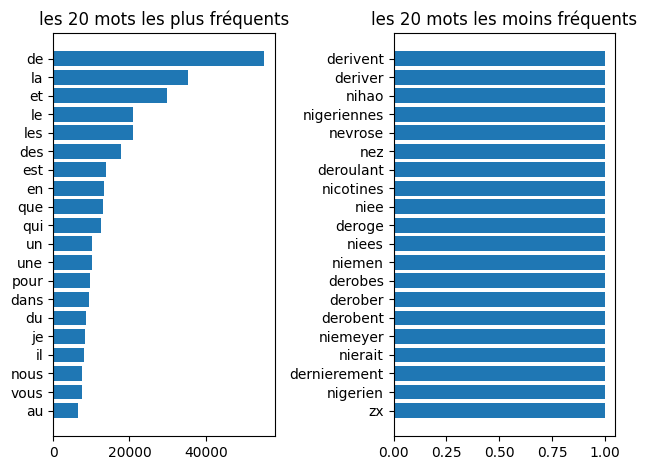

In [9]:
# Aperçu des mots les plus et moins fréquents
# dans le set d'apprentissage après les pré-traitements
vocabulaire = np.array(vectorizer.get_feature_names_out())
comptage = X_train_processing.toarray().sum(0)
n = 20

ind = comptage.argsort()[-n:]
plt.subplot(1, 2, 1)
plt.barh(vocabulaire[ind], comptage[ind])
plt.title("les "+str(n)+" mots les plus fréquents")

ind = comptage.argsort()[:n]
plt.subplot(1, 2, 2)
plt.barh(vocabulaire[ind], comptage[ind])
plt.title("les "+str(n)+" mots les moins fréquents")

plt.tight_layout()

Ce n'est pas encore très parlant. On peut déjà remarquer d'une part que les mots les plus communs sont principalement des déterminants et des pronoms donc très répandus et peu informatifs. D'autre part, on peut soupçonner qu'un grand nombre de mots ne sont présents qu'une fois et donc ne peuvent servir à discriminer entre les orateurs.  

Les pré-traitements déjà réalisés ne sont pas non plus anodins puisqu'ils ont déjà permis de réduire la taille du vocabulaire de moitié, comme on peut le voir ci-dessous.

In [10]:
# Observation des mots les plus fréquents dans le corpus d'entrainement
from collections import Counter

wc = Counter()
for text in X_train:
    wc.update(text.split(" "))

print("Avant le data processing :")
print(f"   - la taille du vocabulaire est de {len(wc)} mots.")
print("   - les 20 mots les plus fréquents sont :")
print(wc.most_common(20))

print("\nAprès le data processing :")
print(f"   - la taille du vocabulaire est de {len(vocabulaire)} mots.")
print("   - les 20 mots les plus fréquents sont :")
ind = comptage.argsort()[-n:]
print(vocabulaire[ind][::-1])

Avant le data processing :
   - la taille du vocabulaire est de 53848 mots.
   - les 20 mots les plus fréquents sont :
[('de', 54901), ('', 45930), ('la', 31797), ('et', 27729), ('à', 20757), ('les', 19450), ('le', 19287), ('des', 17229), ('que', 12556), ('qui', 11797), ('en', 11426), ('pour', 8855), ('dans', 8752), ('du', 8497), ('un', 7443), ('une', 7135), ('plus', 5687), ('nous', 5684), ('au', 5646), ('vous', 5586)]

Après le data processing :
   - la taille du vocabulaire est de 25278 mots.
   - les 20 mots les plus fréquents sont :
['de' 'la' 'et' 'le' 'les' 'des' 'est' 'en' 'que' 'qui' 'un' 'une' 'pour'
 'dans' 'du' 'je' 'il' 'nous' 'vous' 'au']


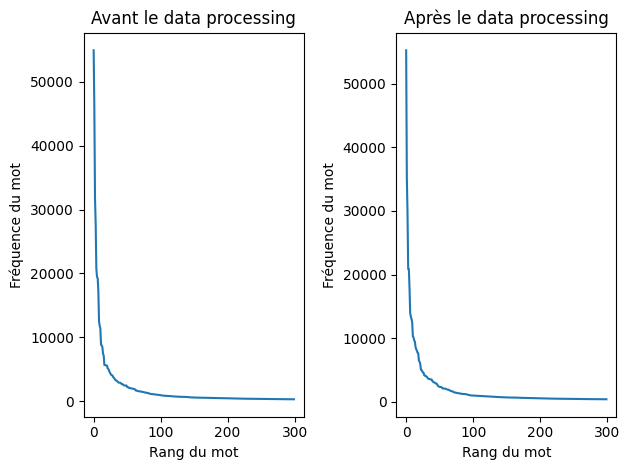

In [11]:
freq = [f for w,f in wc.most_common(1000)]

plt.subplot(1, 2, 1)
plt.plot(freq[:300])
plt.title("Avant le data processing")
plt.xlabel("Rang du mot")
plt.ylabel("Fréquence du mot")

col_sum = np.sum(X_train_processing, axis=0)
col_sum = np.squeeze(np.asarray(col_sum))
col_sum = np.sort(col_sum, axis=0)[::-1]

plt.subplot(1, 2, 2)
plt.plot(col_sum[:300])
plt.title("Après le data processing")
plt.xlabel("Rang du mot")
plt.ylabel("Fréquence du mot")

plt.tight_layout()

Par curiosité, essayons de réaliser d'autres pré-traitements pour voir leur influence sur les figures ci-dessus.

In [53]:
# Création d'un objet de type CountVectorizer
vectorizer_curious = CountVectorizer(
    stop_words=stopwords,  
    strip_accents='ascii',
    lowercase=True 
    )

X_train_curious = vectorizer_curious.fit_transform(X_train)

c:\Users\corne\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca', 'chere', 'cheres', 'cinquantieme', 'cinquieme', 'debut', 'dela', 'deuxieme', 'deuxiemement', 'differente', 'dixieme', 'douzieme', 'etaient', 'etais', 'etait', 'etat', 'ete', 'etee', 'etees', 'etes', 'etiez', 'etions', 'eumes', 'eutes', 'excepte', 'facon', 'fumes', 'futes', 'he', 'helas', 'hola', 'huitieme', 'neuvieme', 'nommes', 'notres', 'ohe', 'ole', 'olle', 'onzieme', 'particuliere', 'particulierement', 'passe', 'piece', 'plutot', 'premiere', 'premierement', 'quatrieme', 'quatriemement', 'quelqu', 'revoila', 'septieme', 'sixieme', 'troisieme', 'troisiemement', 've', 'voila', 'votres'] not in stop_words.
  warnings.warn(


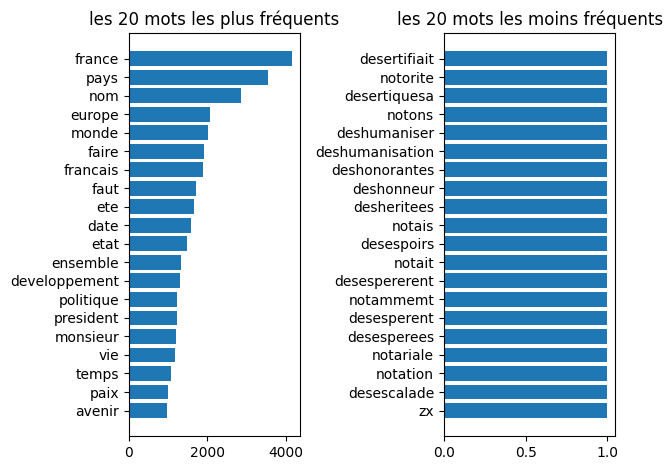

In [54]:
# Aperçu des mots les plus et moins fréquents
# dans le set d'apprentissage après les pré-traitements
vocabulaire = np.array(vectorizer_curious.get_feature_names_out())
comptage = X_train_curious.toarray().sum(0)
n = 20

ind = comptage.argsort()[-n:]
plt.subplot(1, 2, 1)
plt.barh(vocabulaire[ind], comptage[ind])
plt.title("les "+str(n)+" mots les plus fréquents")

ind = comptage.argsort()[:n]
plt.subplot(1, 2, 2)
plt.barh(vocabulaire[ind], comptage[ind])
plt.title("les "+str(n)+" mots les moins fréquents")

plt.tight_layout()

In [55]:
wc = Counter()
for text in X_train:
    wc.update(text.split(" "))

print("Avant le data processing :")
print(f"   - la taille du vocabulaire est de {len(wc)} mots.")
print("   - les 20 mots les plus fréquents sont :")
print(wc.most_common(20))

print("\nAprès le data processing :")
print(f"   - la taille du vocabulaire est de {len(vocabulaire)} mots.")
print("   - les 20 mots les plus fréquents sont :")
ind = comptage.argsort()[-n:]
print(vocabulaire[ind][::-1])

Avant le data processing :
   - la taille du vocabulaire est de 53848 mots.
   - les 20 mots les plus fréquents sont :
[('de', 54901), ('', 45930), ('la', 31797), ('et', 27729), ('à', 20757), ('les', 19450), ('le', 19287), ('des', 17229), ('que', 12556), ('qui', 11797), ('en', 11426), ('pour', 8855), ('dans', 8752), ('du', 8497), ('un', 7443), ('une', 7135), ('plus', 5687), ('nous', 5684), ('au', 5646), ('vous', 5586)]

Après le data processing :
   - la taille du vocabulaire est de 24812 mots.
   - les 20 mots les plus fréquents sont :
['france' 'pays' 'nom' 'europe' 'monde' 'faire' 'francais' 'faut' 'ete'
 'date' 'etat' 'ensemble' 'developpement' 'politique' 'president'
 'monsieur' 'vie' 'temps' 'paix' 'avenir']


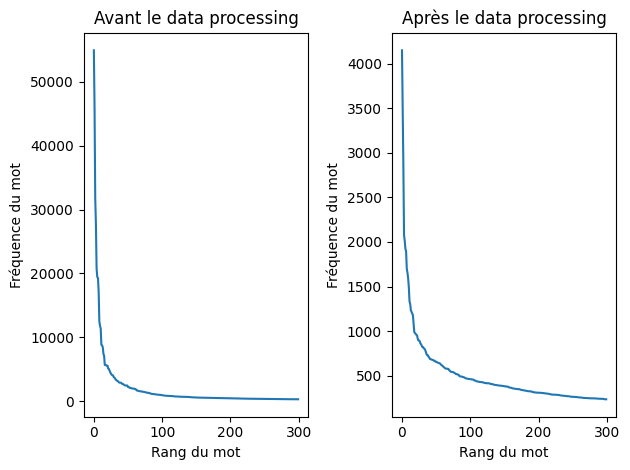

In [56]:
freq = [f for w,f in wc.most_common(1000)]

plt.subplot(1, 2, 1)
plt.plot(freq[:300])
plt.title("Avant le data processing")
plt.xlabel("Rang du mot")
plt.ylabel("Fréquence du mot")

col_sum = np.sum(X_train_curious, axis=0)
col_sum = np.squeeze(np.asarray(col_sum))
col_sum = np.sort(col_sum, axis=0)[::-1]

plt.subplot(1, 2, 2)
plt.plot(col_sum[:300])
plt.title("Après le data processing")
plt.xlabel("Rang du mot")
plt.ylabel("Fréquence du mot")

plt.tight_layout()

### **<span style="color: #DC143C">C. Apprentissage d'un classifieur</span>**

In [12]:
counter = Counter(y_train)
print(f"{round(counter[1] / counter[-1] * 100, 2)}% des phrases sont de Mitterand dans le set d'apprentissage.")

counter = Counter(y_test)
print(f"{round(counter[1] / counter[-1] * 100, 2)}% des phrases sont de Mitterand dans le set de test.")

15.15% des phrases sont de Mitterand dans le set d'apprentissage.
14.81% des phrases sont de Mitterand dans le set de test.


Les classes ne sont visiblement pas équilibrées : il y a environ 15% d'une classe et 85% de l'autre. Nous devons donc prendre quelques mesures de précaution.  

En particulier, nous préférerons l'utilisation de la métrique *balanced_accuracy* à *accuracy* qui surestimerait les performances des modèles.

Nous testerons dans la suite de ce notebook trois modèles de classification :
- Naive Bayes
- SVM
- Régression logistique

In [13]:
# Chargement des librairies pour l'apprentissage
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

# Apprentissage et prédiction
clf_nb = MultinomialNB()
clf_lr = LogisticRegression(random_state=42)
clf_svm = LinearSVC(random_state=42)

clf_nb.fit(X_train_processing,y_train)
clf_lr.fit(X_train_processing,y_train)
clf_svm.fit(X_train_processing,y_train)

pred_nb = clf_nb.predict(X_test_processing)
pred_lr = clf_lr.predict(X_test_processing)
pred_svm = clf_svm.predict(X_test_processing)

c:\Users\corne\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\corne\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\corne\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [14]:
# Affichage des performances des modèles
print(f"Naïve Bayes accuracy: {accuracy_score(y_test, pred_nb)}")
print(f"Naïve Bayes balanced accuracy: {balanced_accuracy_score(y_test, pred_nb)}")
print(f"\nLogistic Regression accuracy: {accuracy_score(y_test, pred_lr)}")
print(f"Logistic Regression balanced accuracy: {balanced_accuracy_score(y_test, pred_lr)}")
print(f"\nSVM accuracy: {accuracy_score(y_test, pred_svm)}")
print(f"SVM balanced accuracy: {balanced_accuracy_score(y_test, pred_svm)}")

Naïve Bayes accuracy: 0.8961072890359663
Naïve Bayes balanced accuracy: 0.7194699817632693

Logistic Regression accuracy: 0.9030741095532526
Logistic Regression balanced accuracy: 0.6938443506437133

SVM accuracy: 0.8864408255682313
SVM balanced accuracy: 0.7156468098682762


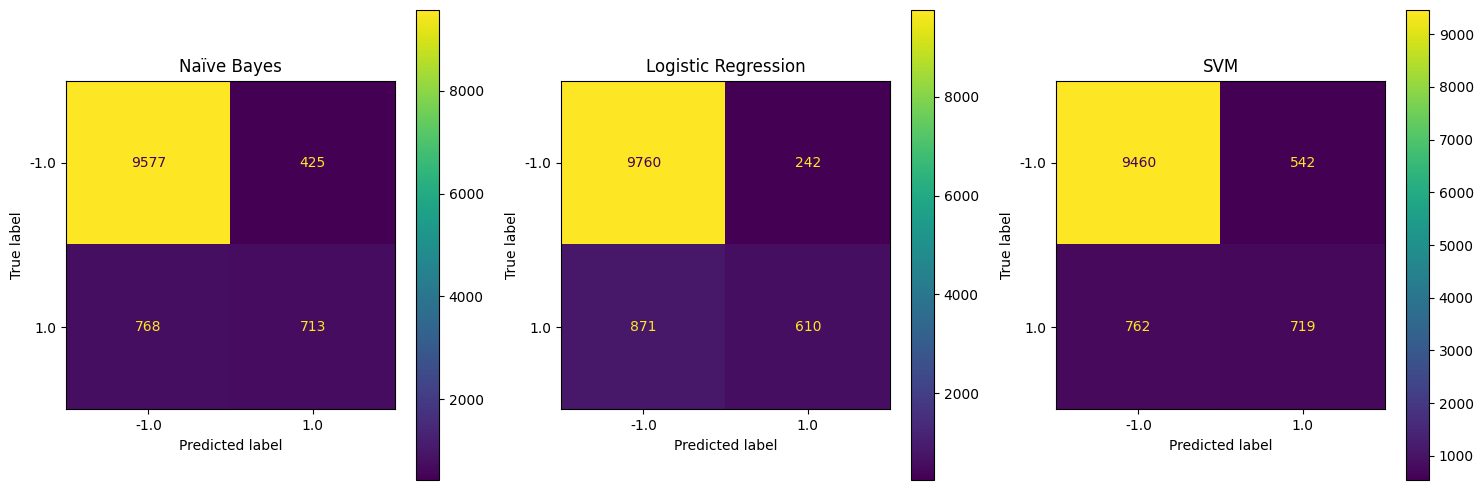

In [15]:
# Matrices de confusion des modèles
from sklearn.metrics import ConfusionMatrixDisplay

figure, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

ax1.set_title("Naïve Bayes")
ConfusionMatrixDisplay.from_predictions(y_test, pred_nb, ax=ax1)
ax2.set_title("Logistic Regression")
ConfusionMatrixDisplay.from_predictions(y_test, pred_lr, ax=ax2)
ax3.set_title("SVM")
ConfusionMatrixDisplay.from_predictions(y_test, pred_svm, ax=ax3)

plt.tight_layout()

### **<span style="color: #DC143C">D. Construction de la chaîne</span>**

Comme nous avons pu le voir plus tôt, les classes sont assez déséquilibrées. Il est donc préférable d'utiliser des outils du modules imblearn pour construire la chaîne de traitements.

In [16]:
# Création d'une pipeline pour le traitement du texte
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Fonction pour créer la pipeline de classification
def classifier(vectorizer, clf):
    pipeline = Pipeline([("Data_processing", vectorizer),
                         ("Resampling", SMOTE(random_state=42)),
                         ("Classification", clf)])
    return pipeline

# Fonction pour évaluer les modèles
def metriques(model_name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    
    print(f"{model_name} accuracy: {acc}")
    print(f"{model_name} balanced accuracy: {bal_acc}")
    return y_pred

# Fonction globale pour la chaine de traitement
def chaine_pretraitement(model, vectorizer, clf, X_train, y_train, X_test, y_test):
    model = classifier(vectorizer, clf)
    y_pred = metriques(model, model, X_train, y_train, X_test, y_test)
    return y_pred

Pipeline(steps=[('Data_processing', CountVectorizer(strip_accents='ascii')),
                ('Resampling', SMOTE(random_state=42)),
                ('Classification', MultinomialNB())]) accuracy: 0.8563964120874336
Pipeline(steps=[('Data_processing', CountVectorizer(strip_accents='ascii')),
                ('Resampling', SMOTE(random_state=42)),
                ('Classification', MultinomialNB())]) balanced accuracy: 0.7403927384678365


c:\Users\corne\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('Data_processing', CountVectorizer(strip_accents='ascii')),
                ('Resampling', SMOTE(random_state=42)),
                ('Classification', LogisticRegression(random_state=42))]) accuracy: 0.8280937037359575
Pipeline(steps=[('Data_processing', CountVectorizer(strip_accents='ascii')),
                ('Resampling', SMOTE(random_state=42)),
                ('Classification', LogisticRegression(random_state=42))]) balanced accuracy: 0.7152297764619933


c:\Users\corne\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\corne\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('Data_processing', CountVectorizer(strip_accents='ascii')),
                ('Resampling', SMOTE(random_state=42)),
                ('Classification', LinearSVC(random_state=42))]) accuracy: 0.8265261691195681
Pipeline(steps=[('Data_processing', CountVectorizer(strip_accents='ascii')),
                ('Resampling', SMOTE(random_state=42)),
                ('Classification', LinearSVC(random_state=42))]) balanced accuracy: 0.7039756464642251


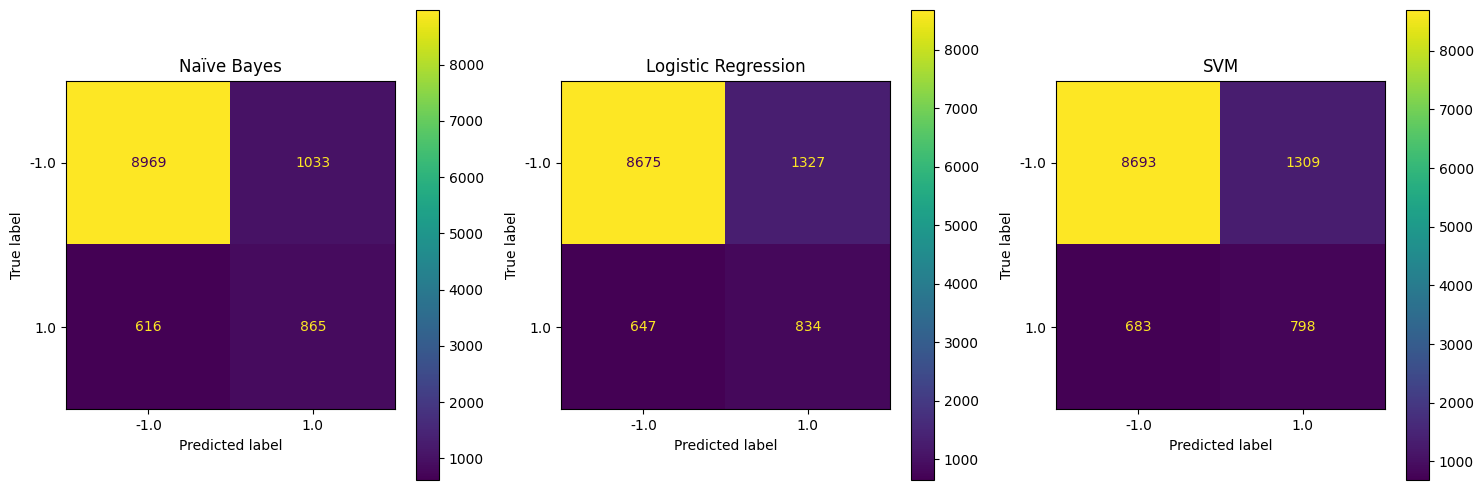

In [17]:
y_pred_nb = chaine_pretraitement("Naïve Bayes", vectorizer, clf_nb, 
                                 X_train, y_train, X_test, y_test)
y_pred_lr = chaine_pretraitement("Logistic Regression", vectorizer, clf_lr,
                                 X_train, y_train, X_test, y_test)
y_pred_svm = chaine_pretraitement("SVM", vectorizer, clf_svm,
                                  X_train, y_train, X_test, y_test)

figure, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

ax1.set_title("Naïve Bayes")
cm_nb = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nb, ax=ax1)
ax2.set_title("Logistic Regression")
cm_lr = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, ax=ax2)
ax3.set_title("SVM")
cm_svm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, ax=ax3)

plt.tight_layout()

## **<span style="color: #40E0D0">2. Exploitation de la chaîne de pré-traitements</span>**

### **<span style="color: #DC143C">A. Optimisation des hyperparamètres</span>**

L'algorithme d'optimisation du classifieur de régression logistique n'a pas convergé ce qui signifie qu'il n'a pas réussi à atteindre une solution stable dans le nombre maximum d'itérations défini (100 par défaut).  

Pour cette raison, nous ne chercherons pas à optimiser ses paramètres dans la suite de ce notebook.

In [18]:
# Chargement des librairies pour l'optimisation des hyperparamètres
from sklearn.model_selection import GridSearchCV

# Fonction pour identifier les meilleurs hyperparamètres
def HyperParamOptimisation(vectorizer, clf, parameters, X_train, y_train,):
    pipeline = classifier(vectorizer, clf)
    params = parameters
    
    grid = GridSearchCV(estimator=pipeline, param_grid=params,
                        scoring='balanced_accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)

    print('Best Score: ', grid.best_score_)
    print('Best Params: ', grid.best_params_)

    return grid.best_params_

In [19]:
# Optimisation des hyperparamètres du modèle Naïve Bayes
parameters = {'Classification__alpha': [0, 0.1, 1, 10, 100]}

best_params_nb = HyperParamOptimisation(vectorizer, clf_nb, parameters, X_train, y_train)

Best Score:  0.7304854088547594
Best Params:  {'Classification__alpha': 1}


In [20]:
# Optimisation des hyperparamètres du modèle SVM
parameters = {'Classification__C': [0.1, 1, 10, 100]}

best_params_svm = HyperParamOptimisation(vectorizer, clf_svm, parameters, X_train, y_train)

c:\Users\corne\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Best Score:  0.7015564705810426
Best Params:  {'Classification__C': 0.1}


Comparé aux essais du 2.C, l'optimisation des paramètres des classifieurs utilisés a bien permis une **légère amélioration de la performance des modèle**. La balanced accuracy du **Naïve Bayes** est ainsi passée de 0.71 à 0.73.  

Etant montré que ce classifieur, avec son paramètre alpha égal à 1, avait le meilleure performance, c'est avec celui-ci que nous continueront dans la suite de ce notebook.


### **<span style="color: #DC143C">B. Campagne de test sur les pré-traitements des données possibles</span>**

Dans cette partie, nous allons réaliser plusieurs tests afin de déterminer les pré-traitements permettant la meilleure performance sur le modèle.   

Nous nous appuyerons pour cela sur l'outil GridSearchCV.

Une fois les paramètres optimaux déterminés, nous pourrons définir le modèle final dans l'ultima partie de ce notebook.

In [21]:
# Fonction pour obtenir les résultats de la grid search
def grid_search(vectorizer, clf, parameters, X_train, y_train):
    pipeline = classifier(vectorizer, clf)
    params = parameters
    
    grid = GridSearchCV(pipeline, params, scoring='balanced_accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    print(grid.best_score_)
    print(grid.best_params_)
    return grid.cv_results_

In [22]:
# Ensemble des paramètres à tester
parameters = {'Data_processing__stop_words':[None, stopwords],
              'Data_processing__preprocessor':[None, stemmer],
              'Data_processing__max_df': [500, 1000, 5000],
              'Data_processing__min_df': [2, 4, 6],
              'Data_processing__ngram_range': [(1, 1), (1, 2), (1, 3)]}

# Classifieur optimal
clf_nb = MultinomialNB(alpha=1)

# Résultats de la grid search
cv_results = grid_search(vectorizer, clf_nb, parameters, X_train, y_train)

0.7934771611495022
{'Data_processing__max_df': 1000, 'Data_processing__min_df': 4, 'Data_processing__ngram_range': (1, 3), 'Data_processing__preprocessor': None, 'Data_processing__stop_words': None}


Cette campagne nous permet de dire que les **meilleurs pré-traitements** à réaliser sont :
- ne pas avoir de mots-vides
- ne pas faire de stemming
- max_df=1000
- min_df=4
- ngram_range=(1,3)  

Nous pouvons visualiser plus précisement l'influence de ces pré-traitements à l'aide de *heatmaps*.

In [39]:
cv_results = pd.DataFrame(cv_results)
cv_results = cv_results.sort_values(by='mean_test_score', ascending=False)

cv_results.to_csv("results/cv_results.csv", index=False)

In [41]:
cv_results = pd.read_csv('results/cv_results.csv')
cv_results = cv_results[['param_Data_processing__max_df', 'param_Data_processing__min_df','param_Data_processing__ngram_range', 'param_Data_processing__preprocessor', 'param_Data_processing__stop_words', 'mean_test_score', 'std_test_score']]
cv_results.columns = ['max_df', 'min_df', 'ngram_range', 'preprocessor', 'stop_words', 'mean_test_score', 'std_test_score']
cv_results.head()

,max_df,min_df,ngram_range,preprocessor,stop_words,mean_test_score,std_test_score
0,1000,4,"(1, 3)",NaN,NaN,0.793477,0.007732
1,1000,4,"(1, 2)",NaN,NaN,0.793324,0.005751
2,500,4,"(1, 3)",NaN,NaN,0.792848,0.007109
3,500,4,"(1, 2)",NaN,NaN,0.791120,0.006565
4,1000,6,"(1, 2)",NaN,NaN,0.790888,0.006355


In [42]:
# Sélection des lignes qui nous intéressent (ngram_range, preprocessor et stop_words fixés)
cv_results1 = cv_results[(cv_results['ngram_range'] == '(1, 3)') & (cv_results['preprocessor'].isna()) & (cv_results['stop_words'].isna())]
cv_results1 = cv_results1[['max_df', 'min_df', 'mean_test_score']]

# Sélection des lignes qui nous intéressent (preprocessor et stop_words)
cv_results2 = cv_results[(cv_results['ngram_range'] == '(1, 3)') & (cv_results['min_df'] == 4) & (cv_results['max_df'] == 1000)]
cv_results2 = cv_results2[['preprocessor', 'stop_words', 'mean_test_score']]

# Sélection des lignes qui nous intéressent (ngram_range et min_df)
cv_results3 = cv_results[(cv_results['max_df'] == 1000) & (cv_results['preprocessor'].isna()) & (cv_results['stop_words'].isna())]
cv_results3 = cv_results3[['ngram_range', 'min_df', 'mean_test_score']]

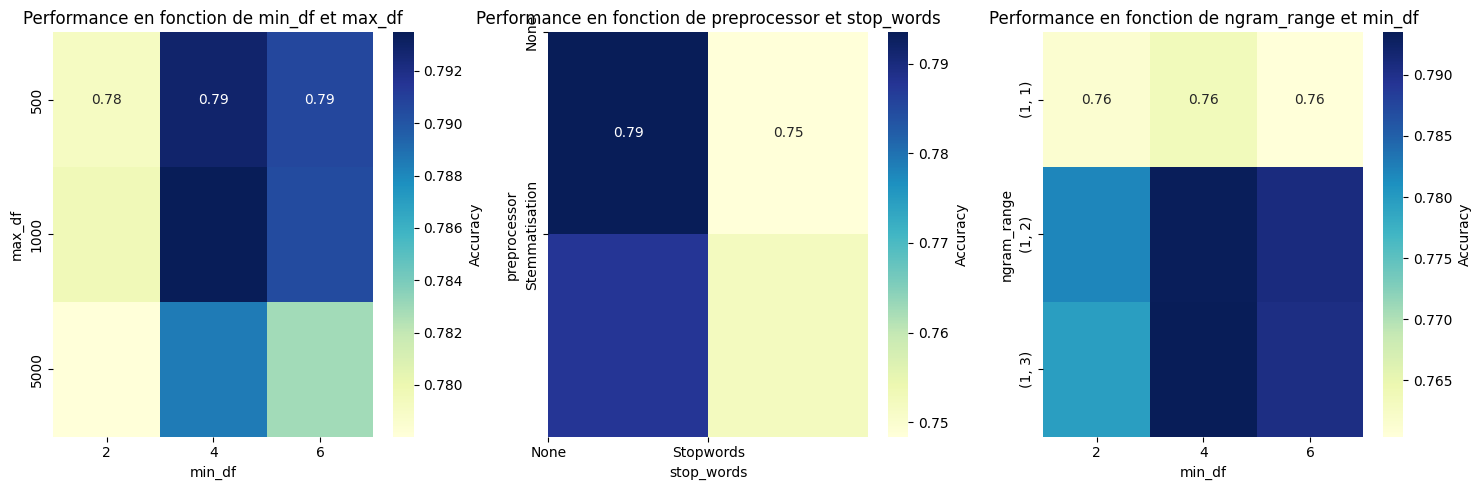

In [43]:
# Représentation des 3 heatmaps
figure, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

# Heatmap 1
ax1.set_title("Performance en fonction de min_df et max_df")
heatmap_data1 = cv_results1.pivot(index='max_df', columns='min_df', values='mean_test_score')
sns.heatmap(heatmap_data1, annot=True, cmap='YlGnBu',cbar_kws={'label': 'Accuracy'}, ax=ax1)

# Heatmap 2
ax2.set_title("Performance en fonction de preprocessor et stop_words")
plt.subplot(1, 3, 2)
heatmap_data2 = cv_results2.pivot(index='preprocessor', columns='stop_words', values='mean_test_score')
sns.heatmap(heatmap_data2, annot=True, cmap='YlGnBu',cbar_kws={'label': 'Accuracy'}, ax=ax2)
plt.yticks(np.arange(2), ('None', 'Stemmatisation'))
plt.xticks(np.arange(2), ('None', 'Stopwords'))
plt.xticks(rotation=0)

# Heatmap 3
ax3.set_title("Performance en fonction de ngram_range et min_df")
heatmap_data3 = cv_results3.pivot(index='ngram_range', columns='min_df', values='mean_test_score')
sns.heatmap(heatmap_data3, annot=True, cmap='YlGnBu',cbar_kws={'label': 'Accuracy'}, ax=ax3)

plt.tight_layout()

## **<span style="color: #40E0D0">3. Application des résultats aux données de test</span>**

### **<span style="color: #DC143C">A. Modèle final</span>**

In [44]:
vectorizer = CountVectorizer(
    strip_accents='ascii', # enlève les accents
    lowercase=True,        # mets en minuscule
    stop_words=None,       # enlève les mots vides
    preprocessor=None,     # applique la fonction stemmer
    max_df=1000,           # nombre max de fois où un mot doit apparaître pour être pris en compte
    min_df=4,              # nombre min de fois où un mot doit apparaître pour être pris en compte
    ngram_range=(1,3)      # ngrammes de taille 1 à 3 (unigrammes, bigrammes et trigrammes)
)

X_train_final = vectorizer.fit_transform(X_train)

# Créer une instance de SVM
clf_final = MultinomialNB(alpha=1)

# Entraîner le modèle SVM sur les données d'entraînement
clf_final.fit(X_train_final, y_train)

MultinomialNB(alpha=1)

### **<span style="color: #DC143C">B. Application aux données du corpus de test</span>**

In [45]:
# Transformation des données avec le vectoriseur avec les paramètres retenus
X_test_data = vectorizer.transform(corpus_test)

# Précitions à partir du modèle retenu
test_predictions = clf_final.predict(X_test_data)

# Sauvegarde des résultats dans un fichier texte
with open("results/resultats.txt", 'w', encoding='utf-8') as file:
    for prediction in test_predictions:
        if prediction == 1:
            file.write("M\n")
        else:
            file.write("C\n")